In [ ]:
### HEAD ###

ipynb = 'ttt-tactics'

import sys, os, json, glob, re, gc
import tensorflow        as tf
import matplotlib.pyplot as plt

from tensorflow           import *
from tensorflow           import strings, ragged, math, random, data, io, linalg, lookup, config, autograph
from numpy                import array    
from ipywidgets           import widgets, HBox, VBox, Layout
from IPython.core.display import display, HTML, Javascript as JS
from pandas               import DataFrame
from pathlib              import Path
from pprint               import pprint
from functools            import partial
from os.path              import isfile,isdir

from tensorflow.train              import BytesList, FloatList, Int64List, Feature, Features, Example
from tensorflow.io                 import TFRecordWriter, FixedLenFeature, VarLenFeature
from tensorflow.data               import TFRecordDataset  
from tensorflow.keras.layers       import Input, Dense, Conv2D, DepthwiseConv2D, Flatten, BatchNormalization, Activation, Add
from tensorflow.keras.losses       import mse, categorical_crossentropy
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations  import softmax
from tensorflow.keras.models       import Model
from tensorflow.keras.metrics      import Metric
from tensorflow.keras.callbacks    import LearningRateScheduler, TensorBoard
from tensorflow.keras.utils        import Progbar, to_categorical, plot_model
from tensorflow.python.client      import device_lib
from tensorflow.math               import is_nan
from tensorflow.config             import run_functions_eagerly
from tensorflow.data.experimental  import AUTOTUNE

from time import *

# %matplotlib inline

STDOUT = sys.stdout

update_nd = tensor_scatter_nd_update

def run_eagerly(yes):
    run_functions_eagerly(run_eagerly=yes)

def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def shuffleall(*xx):
    n   = min([len(x) for x in xx])
    rnd = permutation(n)
    xx  = [x[rnd] for x in xx]
    return tuple(xx)

def time2str(t):
    return strftime("%b %d %Y %H:%M:%S", gmtime(t))

def MTIME(path):
    print(path, time2str(os.path.getmtime(path)))
    
def METHODS(inst):
    pprint(inspect.getmembers(inst, predicate=inspect.ismethod))
    
def NOTIFY(msg, **kwargs):
    from requests import post
    url = 'https://api.pushover.net/1/messages.json?token=ajhpgiiie25dhehjek63q5w2p36r1r&user=umobvvsyqwdhxtgfmued18q6qxfee8';
    return post(url, data = { 'message': msg, **kwargs })

print(device_lib.list_local_devices())
print('tensorflow:', tf.__version__)

DIR   = f'./{ipynb}'
Path(DIR).mkdir(parents=True, exist_ok=True)
print('DIR =', DIR)

TESTS = __name__ == '__main__'

print('MODULE = ', __name__)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8388972004406370600
,
 name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16851259763795730731
physical_device_desc: "device: XLA_CPU device"
]
tensorflow: 2.3.0
DIR = ./ttt-tactics
MODULE =  __main__


In [ ]:
### GAME ###

num_a  = 9*9
size_s = 9*9+9+1

_0_  = constant(0,int64)
_1_  = constant(1,int64)

# 0 1 2
# 3 4 5
# 6 7 8

winidx = ragged.constant([
    [ [[0],[1],[2]],                [[0],[3],[6]], [[0],[4],[8]] ], # 0 - (0,0)
    [ [[0],[1],[2]],                [[1],[4],[7]]                ], # 1 - (0,1)
    [ [[0],[1],[2]], [[2],[4],[6]], [[2],[5],[8]]                ], # 2 - (0,2)
    [ [[3],[4],[5]],                [[0],[3],[6]]                ], # 3 - (1,0)
    [ [[3],[4],[5]], [[2],[4],[6]], [[1],[4],[7]], [[0],[4],[8]] ], # 4 - (1,1)
    [ [[3],[4],[5]],                [[2],[5],[8]]                ], # 5 - (1,2)
    [ [[6],[7],[8]], [[2],[4],[6]], [[0],[3],[6]],               ], # 6 - (2,0)
    [ [[6],[7],[8]],                [[1],[4],[7]]                ], # 7 - (2,1)
    [ [[6],[7],[8]],                [[2],[5],[8]], [[0],[4],[8]] ], # 8 - (2,2)
], int64)

def digits(s):
    return strings.reduce_join(as_string(s))

def other(p): 
    return (p%2)+1

def turn(s):
    return s[-1]

def player(s):
    return other(turn(s))

def index(b,c=0):
    return b*9 + c

def board(a):
    return a // 9

def cell(a):
    return a % 9

def offset(a):
    return a - cell(a)

def boards(s,b,n=1):
    return slice(s,[index(b)],[index(n)])

def emptycells(s,b,n=1):
    return where(boards(s,b,n) == 0)
 
def ravel(x):
    return reshape(x, [-1,])

def unravel(x):
    return reshape(x, [-1,1])

def actions(s):
    return ravel(emptycells(s,0,9))

def iswin(s,a):
    p,c = player(s),cell(a)
    iii = offset(a) + winidx[c]
    fn  = lambda ii: reduce_all(gather_nd(s,ii) == p)
    yyy = map_fn(fn, iii.to_tensor(), fn_output_signature=bool)
    return reduce_any(yyy)

def uniform(n):
    n = cast(n,float32)
    return fill([n],1/n)

def tiebreak(xxx):
    max_x = reduce_max(xxx)
    ii    = where(xxx == max_x)
    pp    = uniform(len(ii))
    ppp   = zeros_like(xxx, dtype=pp.dtype)
    ppp   = update_nd(ppp,ii,pp)
    return ppp

def choice(xx, pp=None):
    pp = math.log([pp])
    i  = random.categorical(pp,1)[0][0]
    return xx[i],i

def game(s=None, a=None):
    winner = -(_1_)
    if s is None:
        s = zeros(size_s,int64)
    else:
        assert_equal(s[a],_0_)                        # inner cell is free
        p   = player(s)
        b,c = board(a),cell(a)
        A   = index(9,b)                              # outer index (board => cell)
        s   = update_nd(s,[[a]],[p])                  # player moves
        if iswin(s,a) and s[A] == 0:                  # player wins board 'b'
            s = update_nd(s,[[A]],[p])              
            if iswin(s,A):                            # player wins game
                winner = p                       
        ii = where(s == -1)
        if len(ii.shape) > 0:                         # restore forbidden cells
            s = update_nd(s, ii, zeros(len(ii),int64))
        aa = emptycells(s,0,9)                        # all free cells
        if len(aa) == 0:
            winner = p if winner > 0 else _0_         # draw
        else:
            ca = index(c) + emptycells(s,c)           # empty cells on board 'c'
            if len(ca) > 0:                           # other may take empty cell on board 'c' only
                s = update_nd(s, aa, -ones(len(aa),int64))
                s = update_nd(s, ca, zeros(len(ca),int64)) 
            else:                                     # other may take any empty cell because board 'c' is over
                s = update_nd(s, aa, zeros(len(aa),int64)) 
            s = update_nd(s,[[size_s-1]],[s[-1] + 1]) # next turn
    return s,winner 

def splitgame(s):
    ss = split(s[0:-1], 10)
    ss = [ reshape(s,[3,3]) for s in ss ]
    S  = concat([concat([ss[0],ss[1],ss[2]], axis=1),
                 concat([ss[3],ss[4],ss[5]], axis=1),
                 concat([ss[6],ss[7],ss[8]], axis=1)], axis=0)
    return S,ss[9],s[-1]    

def joingame(S,s,t):
    S = [ ravel(S[y:y+3,x:x+3]) for y in range(0,9,3) for x in range(0,9,3) ]
    s = concat(S + [ravel(s)] + [[t]], axis=0)
    return s

def selectpi(pi,s):
    actor = player(s)
    if actor == 1: return pi[1](s)
    else:          return pi[2](s)

@function
def testgame(pi):
    s,winner = game()
    while winner < 0:
        aa,pp    = selectpi(pi,s)
        a,_      = choice(aa,pp)        
        s,winner = game(s,a)
    return winner
              
def testgames(pi, iters=TESTS):
    draw     = 0
    agent,*_ = pi.keys()
    rival    = other(agent)
    wins     = array([0,0,0])
    progbar  = Progbar(target=iters, stateful_metrics=['agent','rival','draw'])
    print(f'testgames {agent}:{pi[agent].__name__} vs {rival}:{pi[rival].__name__}')
    for i in range(iters):
        winner        = testgame(pi)
        wins[winner] += 1
        ratios        = wins/(i+1)
        values        = [
            ('agent', ratios[agent]),
            ('rival', ratios[rival]),
            ('draw',  ratios[draw])]
        progbar.update((i+1).numpy(), values=values)  
    return ratios

@function
def samplegame(pi):
    draw     = 0
    sss      = tf.TensorArray(int64,   size=num_a)
    ppp      = tf.TensorArray(float32, size=num_a)
    aaa      = tf.TensorArray(int64,   size=num_a)
    rrr      = tf.TensorArray(int64,   size=num_a)
    n        = 0
    agent    = _1_
    s,winner = game()
    while winner < 0:
        agent = player(s)
        aa,pp = selectpi(pi,s)
        a,_   = choice(aa,pp)    
        zz    = zeros(num_a,float32)
        aa    = unravel(aa)
        p     = update_nd(zz,aa,pp)
        sss   = sss.write(n,s)
        ppp   = ppp.write(n,p)
        aaa   = aaa.write(n,a)
        n    += 1
        s,winner = game(s,a)    
    if   winner == agent: reward =  (_1_)
    elif winner == draw:  reward =  (_0_)
    else:                 reward = -(_1_)
    i = n
    while i > 0:
        rrr    = rrr.write(i-1,reward)
        reward = -reward
        i     -= 1
    return winner,sss.stack(),ppp.stack(),aaa.stack(),rrr.stack(),n

def samplegames(pi, iters=TESTS):
    draw     = 0
    agent,*_ = pi.keys()
    rival    = other(agent)
    wins     = array([0,0,0])
    samples  = []
    progbar  = Progbar(target=iters, stateful_metrics=['episode','agent','rival','draw'])
    print(f'samplegames {agent}:{pi[agent].__name__} vs {rival}:{pi[rival].__name__}')
    for i in range(iters):
        winner,ss,pp,aa,rr,n = samplegame(pi)
        for j in range(n):
            samples.append((ss[j],pp[j],aa[j],rr[j]))
        wins[winner]  += 1
        ratios         = wins/(i+1)
        values         = [
            ('episode', n),
            ('agent',   ratios[agent]),
            ('rival',   ratios[rival]),
            ('draw',    ratios[draw])]
        progbar.update((i+1).numpy(), values=values)  
    return samples

def randompi(s):
    aa = actions(s)
    n  = len(aa)
    pp = uniform(n)
    return aa,pp

if TESTS > 0:
    def print_turn(s):
        print(f'\nturn {turn(s)}, player {player(s)}');  
        aa = actions(s)
        # print('\nactions'); pprint(aa)
        a,i = choice(aa,uniform(len(aa)))
        print('\nchoice',i,board(a),cell(a)); pprint(a)
        s,winner = game(s,a)
        s1       = s
        S,s,t    = splitgame(s)
        print('\nS'); pprint(S)
        print('\ns'); pprint(s)
        print('\nt'); pprint(t)
        s = joingame(S,s,t)
        pprint(reduce_all(s1 == s))
        return s,winner

    # print('\nwinidx')
    # for c in range(9):
    #   pprint(c)
    #   for x in winidx[c]:
    #     pprint(x)

    # s,_ = game()
    # winner = -1
    # while winner < 0 and turn(s) < 2:
    #   s,winner = print_turn(s)
    # print('\nwinner'); pprint(winner)
    
    ratios = testgames({1:randompi,2:randompi}, iters=100)
    print('ratios =', ratios)

    samples = samplegames({1:randompi,2:randompi}, iters=100)
    print('samples:', len(samples))
    (s,p,a,r),_ = choice(samples, uniform(len(samples)))  
    pprint((s,p,a,r))
    
    # for (s,p,a,r) in samples:
    #   print(turn(s),player(s),a,r)


testgames 1:randompi vs 2:randompi
100/100 [==============================] - 5s 51ms/step - agent: 0.3800 - rival: 0.3700 - draw: 0.2500
ratios = [0.25 0.38 0.37]
samplegames 1:randompi vs 2:randompi
100/100 [==============================] - 10s 99ms/step - episode: 75.0000 - agent: 0.5300 - rival: 0.3500 - draw: 0.1200
samples: 7027
(<tf.Tensor: shape=(91,), dtype=int64, numpy=
array([-1,  2, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  2, -1, -1, -1, -1,  2, -1, -1,  1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1, -1, -1, -1, -1, -1,  2, -1, -1,  2, -1, -1, -1, -1,
       -1, -1, -1, -1,  2, -1, -1, -1, -1, -1,  1, -1, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 13])>,
 <tf.Tensor: shape=(81,), dtype=float32, numpy=
array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   

In [ ]:
### DATA ###

def sortedfiles(path):
    paths = list(glob.glob(path)) 
    paths.sort(key=os.path.getmtime)
    return paths            

def map_rotations_and_flips():
    from numpy import arange,rot90,fliplr,flipud
    def rot0(M):     return M
    def rot180(M):   return rot90(M,2)
    def rot270(M):   return rot90(M,3)
    def fliptrbl(M): return transpose(M)
    def fliptlbr(M): return transpose(rot90(M,2))
    rotations = [ rot0,   rot90,  rot180,   rot270   ]
    flips     = [ fliplr, flipud, fliptlbr, fliptrbl ]
    mapping   = {}
    s         = arange(size_s)
    S,s,t     = splitgame(s) 
    for f in rotations+flips:
        ii = joingame(f(S),f(s),t)
        ii = unravel(ii)
        mapping[f.__name__] = ii
    if TESTS > 0:
        for k,v in mapping.items():
            print(k,v)
        print()
    return mapping
    
rotations_and_flips = map_rotations_and_flips()

def kron(a,b,dtype=float32):
  a = linalg.LinearOperatorFullMatrix(cast(a,float32))
  b = linalg.LinearOperatorFullMatrix(cast(b,float32))
  c = linalg.LinearOperatorKronecker([a, b])
  return cast(c.to_dense(), dtype)  

def rotate_and_flip(x):
    if len(x) == size_s:
        return [ gather_nd(x,ii)          for ii in rotations_and_flips.values() ]
    elif len(x) == num_a:
        return [ gather_nd(x,ii[0:num_a]) for ii in rotations_and_flips.values() ]

def onehot(s):
    p     = player(s)
    S,s,_ = splitgame(s)
    M     = cast(S == 0,  int64) * p  # p if p can move here else 0
    mask  = ones([3,3]) 
    W     = kron(s, mask, int64)      # p if p won this sector else 0
    S1    = cast(S == 1,  int64)      # 1 if X is here else 0
    S2    = cast(S == 2,  int64)      # 1 if O is here else 0
    M1    = cast(M == 1,  int64)      # 1 if X can move here else 0
    M2    = cast(M == 2,  int64)      # 1 if O can move here else 0
    W1    = cast(W == 1,  int64)      # 1 if X won this sector else 0
    W2    = cast(W == 2,  int64)      # 1 if O won this sector else 0
    XX    = stack([S1,S2,M1,M2,W1,W2],axis=2)
    return XX   

def savesample(writer, state, probs, reward):
    from numpy import unique
    ss    = rotate_and_flip(state)
    ss,ii = unique(array(ss), axis=0, return_index=True)
    pp    = rotate_and_flip(probs)
    pp    = array(pp)[ii]
    rr    = [reward] * len(pp) 
    for s,p,r in zip(ss,pp,rr):
      sample = Example(
          features=Features(
              feature={
                  'state'  : Feature(int64_list=Int64List(value=s)),
                  'probs'  : Feature(float_list=FloatList(value=p)),
                  'reward' : Feature(int64_list=Int64List(value=[r]))}))
      writer.write(sample.SerializeToString())

@autograph.experimental.do_not_convert
def loadsamples(files, buffer_size=1024, batch_size=64, seed=None):
    proto = { 'state'  : FixedLenFeature([size_s], int64),
              'probs'  : FixedLenFeature([num_a],  float),
              'reward' : FixedLenFeature([1],      int64) }
    def loadsample(sample):
        sample = io.parse_single_example(sample,proto)
        s      = sample['state']
        x      = onehot(s)
        p      = sample['probs']
        r      = sample['reward']
        return {'state':x}, {'policy':p,'value':r}
    ignore_order = data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = data.TFRecordDataset(files)            # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)     # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(loadsample, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

if TESTS > 0:
    path = f'{DIR}/tmp.tfrec'
    (s,p,a,r),_ = choice(samples, uniform(len(samples)))     
    with TFRecordWriter(path) as writer:
        savesample(writer,s,p,r)    
    MTIME(path)      
    files = sortedfiles(path)
    dataset = loadsamples(files)
    for input,output in dataset:
        print(input['state'].shape)
        print(output['policy'].shape)
        print(output['value'].shape)
        for i in range(6):      
            pprint(input['state'][-1][:,:,i])
        pprint(output['policy'][-1])
        pprint(output['value'][-1])


rot0 [[0]
 [1]
 [2]
 ...
 [88]
 [89]
 [90]]
rot90 [[20]
 [23]
 [26]
 ...
 [84]
 [87]
 [90]]
rot180 [[80]
 [79]
 [78]
 ...
 [82]
 [81]
 [90]]
rot270 [[60]
 [57]
 [54]
 ...
 [86]
 [83]
 [90]]
fliplr [[20]
 [19]
 [18]
 ...
 [88]
 [87]
 [90]]
flipud [[60]
 [61]
 [62]
 ...
 [82]
 [83]
 [90]]
fliptlbr [[80]
 [77]
 [74]
 ...
 [84]
 [81]
 [90]]
fliptrbl [[0]
 [3]
 [6]
 ...
 [86]
 [89]
 [90]]

./ttt-tactics/tmp.tfrec Oct 08 2020 14:54:33
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
TensorShape([8, 9, 9, 6])
TensorShape([8, 81])
TensorShape([8, 1])
<tf.Tensor: shape=(9, 9), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 

In [ ]:
### MODEL ###

def ConvLayer(filters     = None, 
              kernel_size = None, 
              strides     = None, 
              padding     = None,
              activation  = None):
    def proc(x, add=None):
        kwargs = dict(kernel_size = kernel_size,
                      strides     = strides,
                      padding     = padding,
                      data_format = 'channels_last',
                      use_bias    = False)
        if filters is None: 
            y = DepthwiseConv2D(depth_multiplier=1, **kwargs)(x)
        else: 
            y = Conv2D(filters=filters, **kwargs)(x)
        y = BatchNormalization()(y)
        if add is not None:
          y = Add()([y, add])  
        z = Activation(activation)(y)
        return z
    return proc

def InputLayer():
    def proc(x):
        z = ConvLayer(filters     = None, 
                      kernel_size = 3, 
                      strides     = 1, 
                      padding     = 'same',
                      activation  = 'relu')(x)
        return z
    return proc

def ResLayer():
    def proc(x):
        kwargs = dict(filters     = None,
                      kernel_size = 3,
                      strides     = 1,
                      padding     = 'same',
                      activation  = 'relu')      
        y = ConvLayer(**kwargs)(x)
        z = ConvLayer(**kwargs)(y, add=x)
        return z
    return proc

def ValueHead():
    def proc(x):
        y = ConvLayer(filters     = 1, 
                      kernel_size = 1, 
                      strides     = 1, 
                      padding     = 'valid',
                      activation  = 'relu')(x)
        y = Flatten()(y)
        y = Dense(64, activation='relu')(y) 
        z = Dense(1, activation='tanh', name='value')(y) 
        return z
    return proc

def PolicyHead():
    def proc(x):
        y = ConvLayer(filters     = 2, 
                      kernel_size = 1, 
                      strides     = 1, 
                      padding     = 'valid',
                      activation  = 'relu')(x)
        y = Flatten()(y)
        z = Dense(num_a, activation='softmax', name='policy')(y)
        return z
    return proc
    
def LearningRateMetric(model):
    def metric(y_true, y_pred):
        return model.optimizer.lr
    metric.__name__ = 'lr'
    return metric    

class AlphaZeroModel(Model):
    def __init__(self, residuals=10, path=None):
        x = Input((9,9,6,), name='state')
        y = InputLayer()(x)
        for i in range(residuals):
            y = ResLayer()(y)
        q = ValueHead()(y)
        p = PolicyHead()(y)
        super(AlphaZeroModel, self).__init__(inputs=x, outputs=[q,p], name='alpha-zero-model')
        self.__name__ = self.name
        self.compile(
            loss         = { 'value': 'mse', 'policy': 'categorical_crossentropy' }, 
            loss_weights = { 'value': 1,     'policy': 1 },
            optimizer    = Adam(lr=0.001, clipnorm=1.0),
            metrics      = { 'value': [LearningRateMetric(self)] }) 
        if path is not None:
            self.load(path)  
    def clone():
        clone = AlphaZeroModel(residuals=residuals)
        clone.set_weights(self.get_weights())
        return clone
    def softmax(self,pp,aa):
          return pp
    def __call__(self, s, training=False, policy=True):
        if training:
            q,ppp = super(AlphaZeroModel, self).__call__(s, training=True)  
            return q,ppp
        aa    = actions(s)
        xx    = stack([onehot(s)])
        q,ppp = super(AlphaZeroModel, self).__call__(xx, training=False)
        q,ppp = squeeze(q),squeeze(ppp)
        ii    = unravel(aa)
        pp    = gather_nd(ppp,ii)
        pp    = softmax(reshape(pp,[1,-1]))
        pp    = reshape(pp, [-1])
        if policy:            
            return aa,pp
        ppp   = zeros(num_a,pp.dtype)
        ppp   = update_nd(ppp,ii,pp)
        return q,ppp
    def __str__(self):
        return self.__name__
    def save(self, path):
        if isfile(path):
            MTIME(path)
            os.rename(path, path+'.bak')       
            MTIME(path+'.bak')
        self.save_weights(path, overwrite=True, save_format='h5')
        MTIME(path)
        self.__name__ = Path(path).stem
    def load(self, path):
        self.load_weights(path)
        MTIME(path)
        self.__name__ = Path(path).stem
  
print(AlphaZeroModel)    

if TESTS > 0:
    model = AlphaZeroModel()
    (s,p,a,r),_ = choice(samples, uniform(len(samples))) 
    pprint(s)
    pprint(p)
    pprint(a)
    aa,pp = model(s)
    pprint(aa)
    pprint(pp)
    aa,pp = model(s, policy=False)
    pprint(aa)
    pprint(pp)
    model.summary()


<class '__main__.AlphaZeroModel'>
<tf.Tensor: shape=(91,), dtype=int64, numpy=
array([-1,  1,  2, -1, -1,  1,  1, -1,  1,  2, -1,  2,  1, -1, -1, -1, -1,
        2, -1,  2, -1,  1,  1, -1,  1,  2,  1,  2,  1,  2,  0,  2,  0,  2,
        2,  0,  2,  1,  1,  1,  2, -1,  2, -1, -1,  2, -1, -1, -1, -1, -1,
       -1,  2, -1, -1, -1,  1,  1,  1, -1,  2, -1,  2, -1, -1, -1,  1,  1,
        1, -1, -1,  1,  1, -1,  2,  1,  2, -1, -1,  2, -1,  0,  0,  0,  2,
        0,  0,  0,  1,  0, 43])>
<tf.Tensor: shape=(81,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333334, 0.        , 0.33333334, 0.        , 0.       

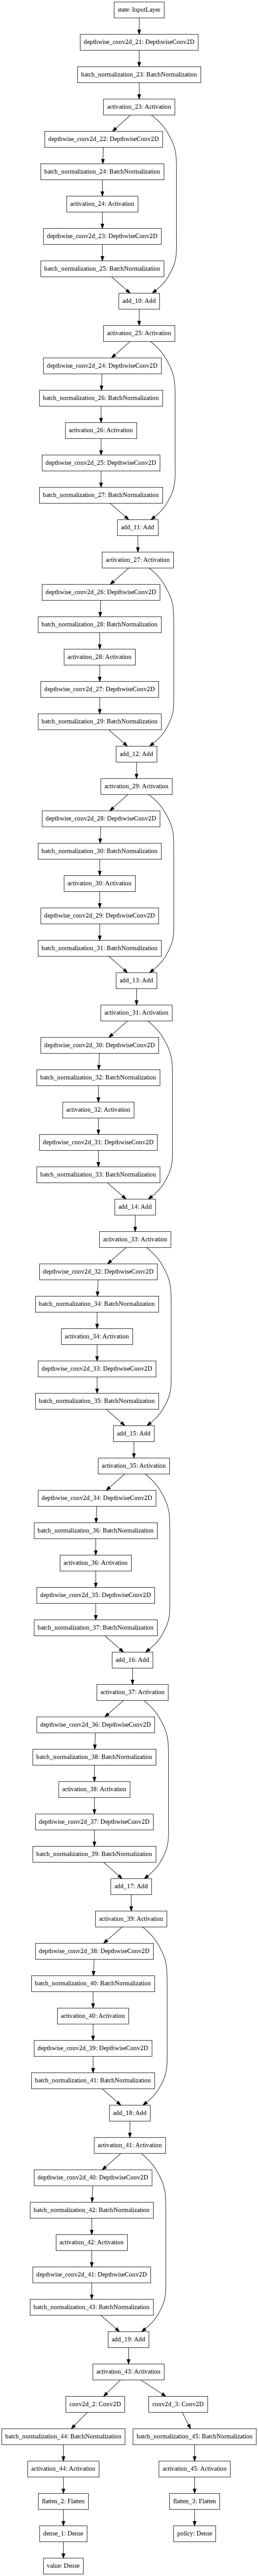

In [ ]:
plot_model(model, show_shapes=False, show_layer_names=True)

In [ ]:
### SEARCH ###

DynamicNodeTable = partial(lookup.experimental.DenseHashTable,
                           key_dtype     = string,
                           value_dtype   = int64,
                           default_value = -1,
                           empty_key     = constant(''),
                           deleted_key   = constant('DELETED'))

DynamicDataTable = partial(lookup.experimental.DenseHashTable,
                           key_dtype     = int64,
                           value_dtype   = float32,
                           default_value = -ones([3*num_a],float32),
                           empty_key     = -1,
                           deleted_key   = -2)

DynamicTensorArray = partial(TensorArray,
                             size             = 0, 
                             dynamic_size     = True, 
                             clear_after_read = False)

def AlphaZeroPolicy(model, times=1, cp=1, tau=1):
    nodes = DynamicNodeTable()
    datas = DynamicDataTable()
    
    def getnode(key):
        return nodes.lookup(key)
                           
    def getdata(node):
        data = datas.lookup(node)
        data = reshape(data,[3,num_a])
        return data
                           
    def setdata(node, data):
        datas.insert_or_assign(node,ravel(data))

    def newdata(pp):
        qq   = zeros(num_a,float32)
        nn   = zeros(num_a,float32)
        data = stack([pp,qq,nn])
        return data

    def newnode(key, pp):
        node = nodes.size()
        data = newdata(pp)
        nodes.insert(key,node)
        setdata(node,data)
        return node

    def updatenode(node, a, q):
        data  = getdata(node)
        cma,n = data[1,a],data[2,a]
        n    += 1
        cma  += (q - cma) / n
        data  = update_nd(data, [[1,a],[2,a]],[cma,n])
        setdata(node,data)

    def puct(node, aa, cp=1):
        data    = getdata(node)
        sum_n   = reduce_sum(data[2])
        puctpqn = lambda p,q,n: q + cp*p*sqrt(sum_n)/(1+n)   
        pucta   = lambda a: puctpqn(p=data[0,a],q=data[1,a],n=data[2,a])    
        uu      = map_fn(pucta, aa, fn_output_signature=float32)
        return tiebreak(uu)

    def pi(node, aa, tau=1):
        data = getdata(node)
        nn   = gather_nd(squeeze(data[2]),unravel(aa))
        if tau == 0:
            return tiebreak(nn)
        nn    = nn**(1/tau)
        sum_n = reduce_sum(nn)
        return nn / sum_n 

    def pushstep(route, a, node):
        depth = route.size()
        step  = stack([a,node])
        route = route.write(depth,step)
        return route

    def backpropagate(route, q):
        depth = route.size()
        while depth > 0:
            step   = route.read(depth-1)
            a,node = step[0],step[1]
            updatenode(node,a,q)
            q      = -q
            depth -=  1

    @function
    @rename(f'searchpi({str(model)},times={times},cp={cp},tau={tau})')
    def searchpi(state):
        for t in range(times):
            route  = DynamicTensorArray(int64)
            s      = state
            q      = 0.0
            actor  = -_1_
            winner = -_1_
            while winner < 0:
                actor = player(s)
                aa    = actions(s)
                key   = digits(s)
                node  = getnode(key)  
                if node < 0:   
                    q,pp = model(s,policy=False)
                    node = newnode(key,pp)    
                    break
                else:
                    pp       = puct(node,aa,cp)  
                    a,_      = choice(aa,pp)  
                    route    = pushstep(route,a,node)
                    s,winner = game(s,a)
            if   winner == actor: q =  1.0
            elif winner == 0:     q =  0.0
            elif winner  > 0:     q = -1.0
            backpropagate(route,-q)
        aa   = actions(state)
        key  = digits(state)
        node = getnode(key)
        pp   = pi(node,aa,tau)
        return aa,pp
    return searchpi

print(AlphaZeroPolicy)

if TESTS:
    autograph.set_verbosity(0, alsologtostdout=False)
    pi = AlphaZeroPolicy(model, times=10, cp=1, tau=1)   
    testgames({1:pi, 2:randompi}, iters=10) 
    testgames({2:pi, 1:randompi}, iters=10)
    samples = samplegames({1:pi,2:pi}, iters=10)
    print('samples:', len(samples))
    (s,p,a,r),_ = choice(samples, uniform(len(samples)))  
    pprint((s,p,a,r))

<function AlphaZeroPolicy at 0x7ff375960048>
testgames 1:searchpi(alpha-zero-model,times=10,cp=1,tau=1) vs 2:randompi
10/10 [==============================] - 19s 2s/step - agent: 0.1000 - rival: 0.5000 - draw: 0.4000
testgames 2:searchpi(alpha-zero-model,times=10,cp=1,tau=1) vs 1:randompi
10/10 [==============================] - 14s 1s/step - agent: 0.3000 - rival: 0.5000 - draw: 0.2000
samplegames 1:searchpi(alpha-zero-model,times=10,cp=1,tau=1) vs 2:searchpi(alpha-zero-model,times=10,cp=1,tau=1)
10/10 [==============================] - 33s 3s/step - episode: 79.0000 - agent: 0.5000 - rival: 0.1000 - draw: 0.4000
samples: 751
(<tf.Tensor: shape=(91,), dtype=int64, numpy=
array([ 1, -1, -1,  2, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1,  2, -1, -1, -1, -1, -1,  1, -1, -1, -1,  0,  0,  0,  0,  2,  0,
        0,  1,  0,  2, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1,
        2, -1, -1,

In [ ]:
### TRY ###

def play(pprint, transformations=False):
    state   = None
    agent   = None
    rival   = None
    
    def moveagent(s, a):
        aa,pp      = pi[agent](s)
        a          = choice(aa, p=pp)
        s,winner = game(s, a)
        return s,winner

    def display_board(onclick):
        cells = []
        for a in range(num_a):
            button = widgets.Button(
                description  = '',
                disabled     = False,
                button_style = 'info', # 'success', 'info', 'warning', 'danger' or ''
                tooltip      = 'Click me',
                icon         = '',
                layout       = Layout(width='40px', height='40px')
            )
            button.action = int64(a)
            button.on_click(lambda btn: onclick(btn.action))
            cells.append(button)
        def box(cells):
            return VBox([
                HBox([cells[0],cells[1],cells[2]]), 
                HBox([cells[3],cells[4],cells[5]]),
                HBox([cells[6],cells[7],cells[8]]), 
            ])
        bb = []
        for i in range(0,9*9,9):
            b = box(cells[i:i+9])
            b.layout.margin = '3px'
            bb.append(b)
        display(box(bb))
        return cells

    def update_board(state):
        chars           = [' ', ' ', 'X', 'O']
        styles          = ['', 'info', 'success', 'danger']
        styles[agent+1] = 'danger'
        styles[rival+1] = 'success'
        state           = state.astype(int)
        state9          = state[boards(9)]
        for a in range(num_a):
            b                     = board(a)
            value                 = state9[b]
            cells[a].button_style = styles[value+1]
            value                 = state[a]
            cells[a].description  = chars[value+1]
            cells[a].disabled     = bool(value != 0)
            cells[a].layout.border = None if cells[a].disabled else 'solid gray 2px'
            
    def gameturn(s=None, a=None):
        s,winner = game(s,a)
        update_board(s)
        if winner is None and player(s) == agent:
            s,winner = moveagent(s,a)
            update_board(s)
        if winner is not None:
            msgs = ['DRAW','X WINS','O WINS']
            print(msgs[winner])
        return s,winner

    def onclick(a): 
        nonlocal state
        if (player(state) == rival) and (a in actions(state)):
            state,winner = gameturn(state,a)

    def transform(fn,_):
        nonlocal state
        state = state[statemap[fn]]
        update_board(state)
            
    def print_state(_):
        for x in represent(state):
            print(x)
            
    assert(1 in pi or 2 in pi)    
    if   1 in pi:
        agent,rival = 1,2
    elif 2 in pi:
        agent,rival = 2,1
    print(f'play against {pi[agent].__name__}')
    
    cells        = display_board(onclick=onclick)
    state,winner = gameturn()

    if transformations:
        buttons = []
        for fn in statemap.keys():
            button = widgets.Button(description=fn, button_style='danger')
            button.on_click(partial(transform,fn))
            buttons.append(button)
        display(HBox(buttons))
    
    button = widgets.Button(description='print state', button_style='warning')
    button.on_click(print_state)
    display(button)

if TESTS > 0:
    play({1:randompi}, transformations=True)

In [ ]:
### STATS ###

stats = {}
path  = f'{DIR}/stats.npy'
if isfile(path):
    stats = load(path, allow_pickle=True)
    stats = stats.item()
    MTIME(path)
    
def addcell(table,col,row,val):
    col,row = str(col),str(row)
    if col not in table: 
        table[col] = {}
    table[col][row] = val

DataFrame(data=stats)